# Twitter Sentiment Analysis

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# NLTK
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec Library
import gensim

# Utility Libraries
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Mcsteve/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Constant Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [5]:
# Load dataset into a dataframe object.
df = pd.read_csv("files/training.1600000.processed.noemoticon.csv", \
                encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
# Display size of the dataset.
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 351 ms, sys: 12.3 ms, total: 363 ms
Wall time: 399 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

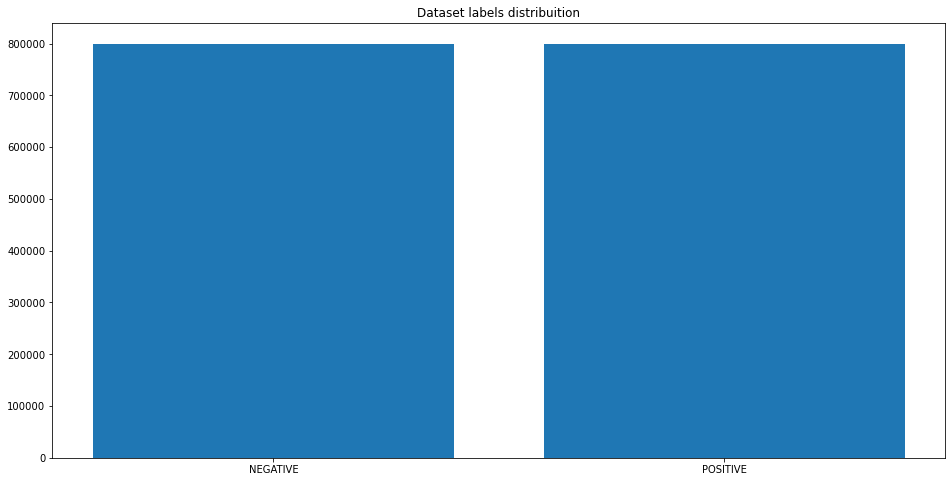

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [12]:
# Implementing stop words and Snowball Stemmer.

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 58.1 s, sys: 1.62 s, total: 59.7 s
Wall time: 1min 14s


### Train, Test Split

In [17]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [18]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.92 s, sys: 876 ms, total: 4.8 s
Wall time: 6.7 s


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-08-10 16:11:41,137 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-08-10T16:11:40.975973', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [21]:
w2v_model.build_vocab(documents)

2022-08-10 16:12:04,850 : INFO : collecting all words and their counts
2022-08-10 16:12:04,853 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-10 16:12:04,886 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-08-10 16:12:04,926 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-08-10 16:12:05,020 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-08-10 16:12:05,066 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-08-10 16:12:05,112 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-08-10 16:12:05,164 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-08-10 16:12:05,225 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-08-10 16:12:05,295 : INFO : PROGRESS: at s

In [24]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [25]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-08-10 16:16:47,848 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-08-10T16:16:47.848506', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
2022-08-10 16:16:49,085 : INFO : EPOCH 0 - PROGRESS: at 4.78% examples, 388323 words/s, in_qsize 15, out_qsize 0
2022-08-10 16:16:50,094 : INFO : EPOCH 0 - PROGRESS: at 13.90% examples, 565099 words/s, in_qsize 15, out_qsize 1
2022-08-10 16:16:51,112 : INFO : EPOCH 0 - PROGRESS: at 23.09% examples, 625277 words/s, in_qsize 14, out_qsize 1
2022-08-10 16:16:52,119 : INFO : EPOCH 0 - PROGRESS: at 32.08% examples, 652377 words/s, in_qsize 16, out_qsize 0
2022-08-10 16:16:53,119 : INFO : EPOCH 0 - PROGRESS: at 41.70% examples, 680170 words/s, in_qsize 14, out_qsize 0
2022-08-10 16:16:54,143 : INFO 

CPU times: user 16min 50s, sys: 11 s, total: 17min 1s
Wall time: 5min 51s


(263127692, 295270464)

In [32]:
w2v_model.wv.most_similar("cold")

[('chilly', 0.5416432023048401),
 ('warm', 0.5029444098472595),
 ('freezing', 0.4821039140224457),
 ('windy', 0.4698352813720703),
 ('winter', 0.4631253182888031),
 ('stuffy', 0.4474879205226898),
 ('heat', 0.4459328055381775),
 ('muggy', 0.4435514509677887),
 ('humid', 0.44161131978034973),
 ('colds', 0.4382340610027313)]

### Tokenize Text

In [33]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 17.5 s, sys: 506 ms, total: 18 s
Wall time: 19.6 s


In [34]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 25.7 s, sys: 2.9 s, total: 28.6 s
Wall time: 32.4 s


In [36]:
type(x_train)

numpy.ndarray

### Label Encoder for Target label encoding

In [37]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [38]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [41]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print()
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (1280000, 300)
y_train: (1280000, 1)

x_test: (320000, 300)
y_test: (320000, 1)


In [42]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [43]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [44]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [45]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-08-10 16:30:44.061894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [47]:
# Change patience to 2 or 3; val_acc to val_accuracy or val_loss; Reduce epochs to 4/6.
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0, mode='auto'),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)]

### Train

In [48]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.7498 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-10 19:44:43,815 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 11612s 10s/step - loss: 0.5044 - accuracy: 0.7498 - val_loss: 0.4662 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.7680 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-10 23:13:00,938 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 12497s 11s/step - loss: 0.4783 - accuracy: 0.7680 - val_loss: 0.4566 - val_accuracy: 0.7839 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.7722WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-11 01:45:55,781 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 9175s 8s/step - loss: 0.4711 - accuracy: 0.7722 - val_loss: 0.4534 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7746WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-11 04:14:45,815 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 8930s 8s/step - loss: 0.4674 - accuracy: 0.7746 - val_loss: 0.4514 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.7760WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-11 06:46:20,242 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 9094s 8s/step - loss: 0.4648 - accuracy: 0.7760 - val_loss: 0.4483 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.7698WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-11 09:24:17,133 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 9477s 8s/step - loss: 0.4768 - accuracy: 0.7698 - val_loss: 0.4524 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.7746 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-11 13:07:36,214 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 13399s 12s/step - loss: 0.4681 - accuracy: 0.7746 - val_loss: 0.4485 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.7777WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-08-11 16:10:18,391 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10962s 10s/step - loss: 0.4631 - accuracy: 0.7777 - val_loss: 0.4469 - val_accuracy: 0.7905 - lr: 0.0010
CPU times: user 1d 19h 29min 26s, sys: 18h 30min, total: 2d 13h 59min 26s
Wall time: 23h 39min 7s


### Evaluate

In [49]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 656s 2s/step - loss: 0.4461 - accuracy: 0.7907

ACCURACY: 0.7907218933105469
LOSS: 0.44612666964530945
CPU times: user 20min 33s, sys: 4min 26s, total: 24min 59s
Wall time: 10min 57s


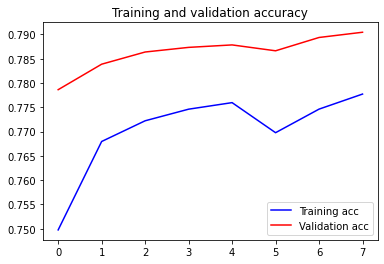

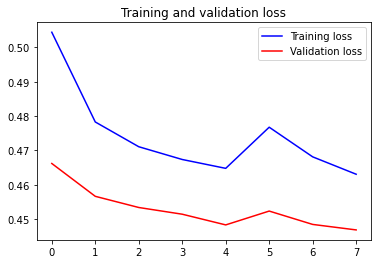

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [51]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [52]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [53]:
predict("I love the music")

1/1 [==============================] - 2s 2s/step


{'label': 'POSITIVE',
 'score': 0.9703062772750854,
 'elapsed_time': 3.423229932785034}

In [54]:
predict("I hate the rain")

1/1 [==============================] - 0s 72ms/step


{'label': 'NEGATIVE',
 'score': 0.006820933893322945,
 'elapsed_time': 0.1456451416015625}

In [55]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 58ms/step


{'label': 'NEGATIVE',
 'score': 0.3701082468032837,
 'elapsed_time': 0.12126398086547852}

### Confusion Matrix

In [56]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 813s 20s/step
CPU times: user 19min 57s, sys: 7min 49s, total: 27min 46s
Wall time: 13min 34s


In [57]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

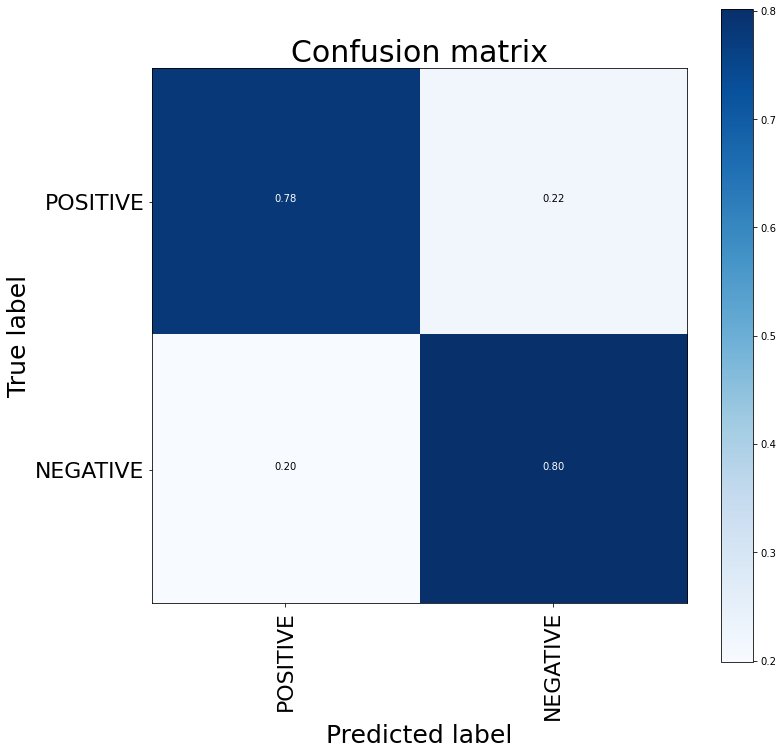

CPU times: user 1.52 s, sys: 333 ms, total: 1.85 s
Wall time: 3.17 s


In [58]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [59]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [60]:
accuracy_score(y_test_1d, y_pred_1d)

0.790721875

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)